<a href="https://colab.research.google.com/github/divyaprabha123/ATOM/blob/master/Copy_of_SIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/sekilab/RoadDamageDetector.git

Cloning into 'RoadDamageDetector'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 366 (delta 8), reused 0 (delta 0), pack-reused 350
Receiving objects: 100% (366/366), 4.90 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (175/175), done.


## Road Damage Detection

In [0]:
import sys
sys.path.append("/content/RoadDamageDetector/")

In [0]:
import numpy as np
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# if tf.__version__ != '1.4.1':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.1!')

from utils import label_map_util

from utils import visualization_utils as vis_util

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 42kB/s 
     |████████████████████████████████| 368kB 51.3MB/s 
     |████████████████████████████████| 3.2MB 51.6MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# ![alt text](https://drive.google.com/uc?id=1MiaRqHoFel01ZpCmvY3T8VZHpHe6oyO2)

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT =  '/content/drive/My Drive/SIH/ssd_mobilenet_RoadDamageDetector.pb' 

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/drive/My Drive/SIH/crack_label_map.pbtxt'

NUM_CLASSES = 8

In [0]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
category_index

{1: {'id': 1, 'name': 'D00'},
 2: {'id': 2, 'name': 'D01'},
 3: {'id': 3, 'name': 'D10'},
 4: {'id': 4, 'name': 'D11'},
 5: {'id': 5, 'name': 'D20'},
 6: {'id': 6, 'name': 'D40'},
 7: {'id': 7, 'name': 'D43'},
 8: {'id': 8, 'name': 'D44'}}

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
def detect(test_image, plot_show = False):
  detection_graph = tf.Graph()
  with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
      serialized_graph = fid.read()
      od_graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(od_graph_def, name='')

  label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
  categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
  category_index = label_map_util.create_category_index(categories)
  cat = np.array(["D00","D01","D10","D11","D20","D40","D43","D44"])
  
  #INPUT FILE
  if str(type(test_image))!="<class 'list'>":
    TEST_IMAGE_PATHS=[test_image]  
  else:
    TEST_IMAGE_PATHS=test_image
  IMAGE_SIZE = (12, 8)
  final_images,boxes_collect,scores_collect,classes_collect,num_collect = [],[],[],[],[]
  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
      # Definite input and output Tensors for detection_graph
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
      detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        min_score_thresh = 0.4
        
        #Select the boxes based on threshold
        sc = np.where(scores[0] > min_score_thresh)[0]
        scores_sel = scores[0][sc]
        boxes_sel = boxes[0][sc,:]
        classes_ind = classes[0][sc]
       
        classes_names = [(cat[int(i-1)]) for i in classes_ind]
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            min_score_thresh=min_score_thresh,
            use_normalized_coordinates=True,
            line_thickness=8)
        if plot_show == True:
          plt.figure(figsize=IMAGE_SIZE)
          plt.imshow(image_np)
        final_images.append(image_np)
        boxes_collect.append(boxes_sel)
        scores_collect.append(scores_sel)
        classes_collect.append(classes_names)
        num_collect.append(num)
  
  return image_np,boxes_collect,scores_collect,classes_collect,test_image

In [0]:
detect("/content/test_image (4).jpg")

(array([[[ 16,  25,  24],
         [ 22,  31,  30],
         [ 23,  32,  31],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 38,  44,  44],
         [ 25,  34,  33],
         [ 21,  30,  29],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 30,  36,  36],
         [ 20,  26,  26],
         [ 11,  20,  19],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 97,  98,  92],
         [124, 125, 119],
         [110, 111, 105],
         ...,
         [ 99, 105, 105],
         [ 75,  81,  81],
         [ 94, 100, 100]],
 
        [[106, 107, 101],
         [ 76,  77,  71],
         [110, 111, 105],
         ...,
         [ 52,  58,  58],
         [ 35,  41,  41],
         [ 62,  68,  68]],
 
        [[103, 104,  98],
         [ 45,  46,  40],
         [ 28,  29,  23],
         ...,
         [ 27,  33,  33],
  

In [0]:
result ={}


In [0]:
file_name = "hhh"
f = "ooo"
result = {'id': file_name, 'Damages': classes_collect, 'Coordinates': boxes_collect }

In [0]:
result

{'1.id': 'hhh',
 '2.Damages': [['D20'], ['D20']],
 '3.Coordinates': [array([[0.62257576, 0.200223  , 0.99273133, 0.9520732 ]], dtype=float32),
  array([[0.6201465 , 0.3894174 , 0.99499357, 0.95104444]], dtype=float32)]}

In [0]:
category_index

{1: {'id': 1, 'name': 'D00'},
 2: {'id': 2, 'name': 'D01'},
 3: {'id': 3, 'name': 'D10'},
 4: {'id': 4, 'name': 'D11'},
 5: {'id': 5, 'name': 'D20'},
 6: {'id': 6, 'name': 'D40'},
 7: {'id': 7, 'name': 'D43'},
 8: {'id': 8, 'name': 'D44'}}

In [0]:
image_np,boxes_collect,scores_collect,classes_collect,num_collect,ind

(array([[[ 16,  25,  24],
         [ 22,  31,  30],
         [ 23,  32,  31],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 38,  44,  44],
         [ 25,  34,  33],
         [ 21,  30,  29],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 30,  36,  36],
         [ 20,  26,  26],
         [ 11,  20,  19],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 97,  98,  92],
         [124, 125, 119],
         [110, 111, 105],
         ...,
         [ 99, 105, 105],
         [ 75,  81,  81],
         [ 94, 100, 100]],
 
        [[106, 107, 101],
         [ 76,  77,  71],
         [110, 111, 105],
         ...,
         [ 52,  58,  58],
         [ 35,  41,  41],
         [ 62,  68,  68]],
 
        [[103, 104,  98],
         [ 45,  46,  40],
         [ 28,  29,  23],
         ...,
         [ 27,  33,  33],
  

In [0]:
c = classes_collect[0][0][sc]

cat = np.array(["D00","D01","D10","D11","D20","D40","D43","D44"])
ci = [(cat[int(i-1)]) for i in c]
ci

['D20']

In [0]:
sc = np.where(scores_collect[0][0] > 0.4)[0]

In [0]:
boxes_collect[0][0][sc,:]

array([[0.6201465 , 0.3894174 , 0.99499357, 0.95104444],
       [0.64632285, 0.608393  , 0.98169684, 0.9920514 ],
       [0.18945011, 0.49266988, 0.9371625 , 0.9724788 ],
       [0.0090898 , 0.27452424, 0.9649751 , 0.81392956],
       [0.5072113 , 0.25715747, 0.9809376 , 0.8648238 ],
       [0.4256184 , 0.05494861, 0.6914011 , 0.23621109],
       [0.51864225, 0.5171455 , 0.97689277, 0.9693768 ],
       [0.31280947, 0.3104753 , 0.97041297, 0.988324  ],
       [0.19084929, 0.26141542, 0.5476334 , 0.34219426],
       [0.52495325, 0.03061596, 0.7492944 , 0.21173894],
       [0.16259477, 0.63100123, 0.7648759 , 0.9996978 ],
       [0.00539631, 0.07965806, 1.        , 0.95525527],
       [0.5444797 , 0.71135134, 0.92792404, 1.        ],
       [0.7277479 , 0.6944985 , 0.95774055, 0.95930034],
       [0.4160678 , 0.3017549 , 0.9530226 , 0.72515684],
       [0.18664344, 0.02019778, 0.55900013, 0.13996007],
       [0.03203171, 0.        , 0.7614151 , 0.69968593]], dtype=float32)

In [0]:
boxes_collect

[array([[[0.6201465 , 0.3894174 , 0.99499357, 0.95104444],
         [0.64632285, 0.608393  , 0.98169684, 0.9920514 ],
         [0.18945011, 0.49266988, 0.9371625 , 0.9724788 ],
         [0.0090898 , 0.27452424, 0.9649751 , 0.81392956],
         [0.5072113 , 0.25715747, 0.9809376 , 0.8648238 ],
         [0.4256184 , 0.05494861, 0.6914011 , 0.23621109],
         [0.51864225, 0.5171455 , 0.97689277, 0.9693768 ],
         [0.31280947, 0.3104753 , 0.97041297, 0.988324  ],
         [0.19084929, 0.26141542, 0.5476334 , 0.34219426],
         [0.52495325, 0.03061596, 0.7492944 , 0.21173894],
         [0.16259477, 0.63100123, 0.7648759 , 0.9996978 ],
         [0.00539631, 0.07965806, 1.        , 0.95525527],
         [0.5444797 , 0.71135134, 0.92792404, 1.        ],
         [0.7277479 , 0.6944985 , 0.95774055, 0.95930034],
         [0.4160678 , 0.3017549 , 0.9530226 , 0.72515684],
         [0.18664344, 0.02019778, 0.55900013, 0.13996007],
         [0.03203171, 0.        , 0.7614151 , 0.69968593

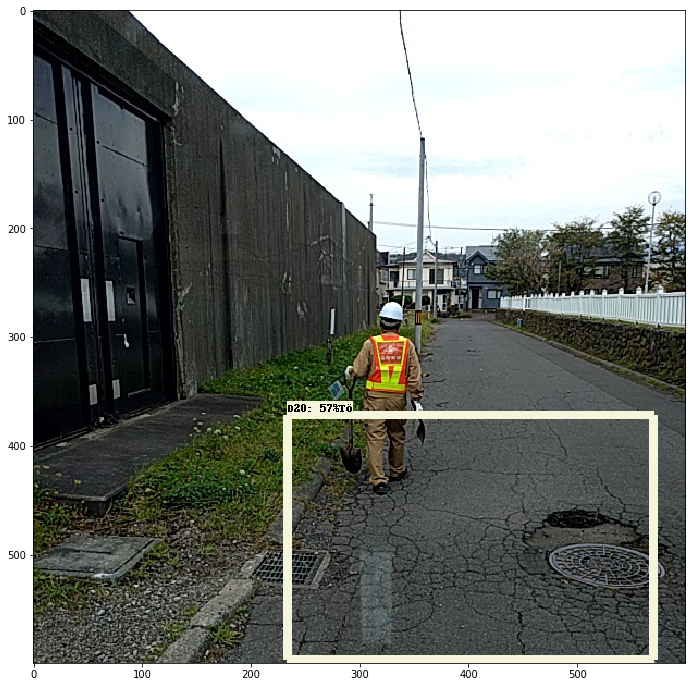

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(image_np)

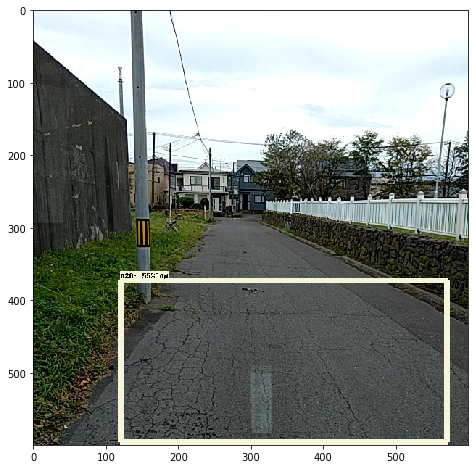

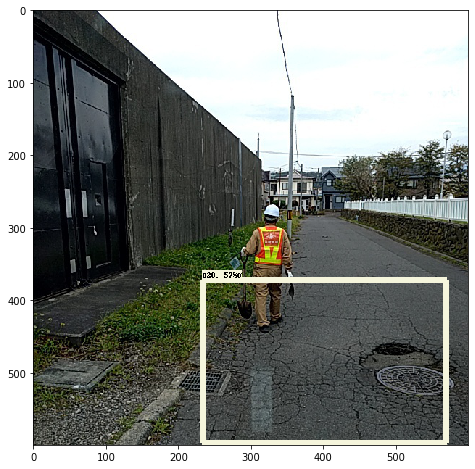

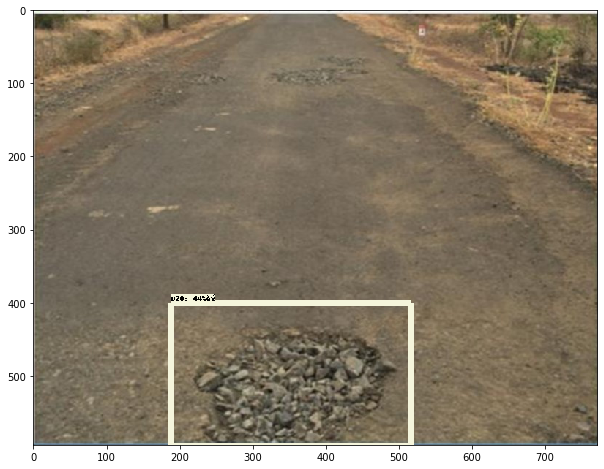

In [0]:
image_np,boxes_collect,scores_collect,classes_collect,test_image  = detect(["/content/test_image (5).jpg","/content/test_image (4).jpg","/content/16.jpg"], plot_show=True)

In [0]:
boxes_collect,scores_collect,classes_collect,test_image

([array([[0.62257576, 0.200223  , 0.99273133, 0.9520732 ]], dtype=float32),
  array([[0.6201465 , 0.3894174 , 0.99499357, 0.95104444]], dtype=float32)],
 [array([0.55294764], dtype=float32), array([0.5796796], dtype=float32)],
 [['D20'], ['D20']],
 ['/content/test_image (5).jpg', '/content/test_image (4).jpg'])

In [0]:
boxes_collect,scores_collect,classes_collect

([array([[0.62257576, 0.200223  , 0.99273133, 0.9520732 ]], dtype=float32),
  array([[0.6201465 , 0.3894174 , 0.99499357, 0.95104444]], dtype=float32)],
 [array([0.55294764], dtype=float32), array([0.5796796], dtype=float32)],
 [['D20'], ['D20']])

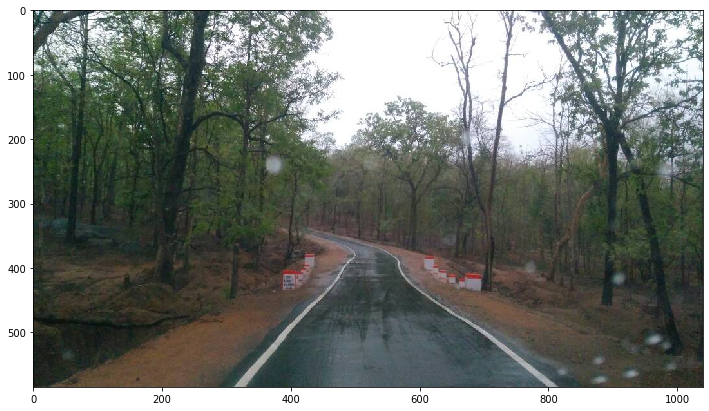

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(image_np)

In [0]:
image_np,boxes_collect,scores_collect,classes_collect,num_collect  = detect("/content/15.jpg")

<class 'str'>


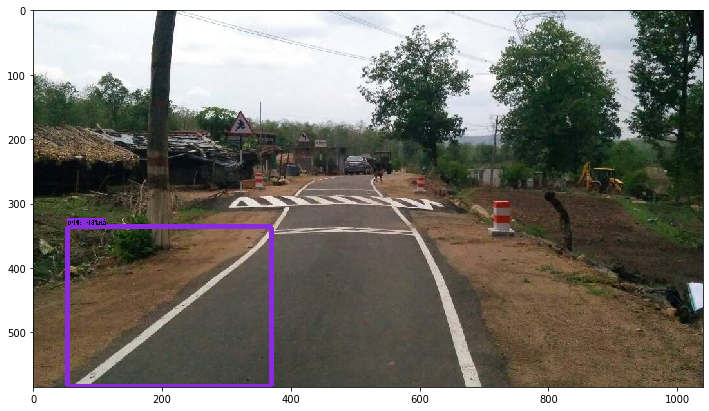

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(image_np)

In [0]:
image_np,boxes_collect,scores_collect,classes_collect,num_collect  = detect("/content/16.jpg")

<class 'str'>


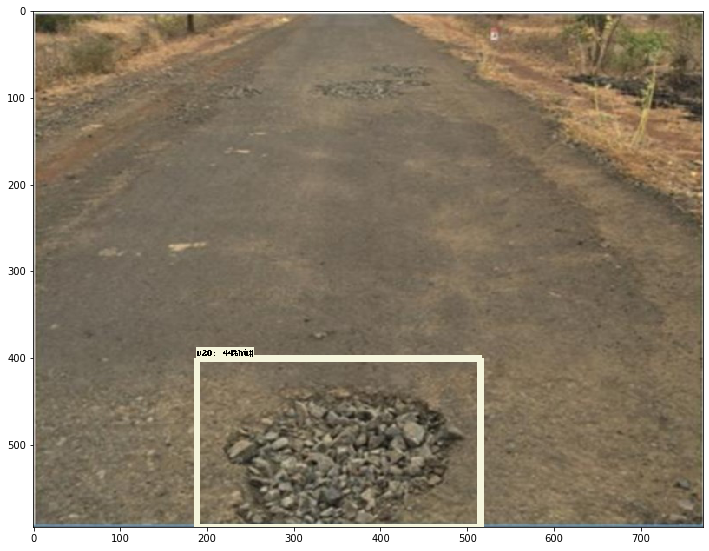

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(image_np)

# Traffic sign detection

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob


In [3]:
!git clone https://github.com/thtrieu/darkflow.git

Cloning into 'darkflow'...
remote: Enumerating objects: 2710, done.
remote: Total 2710 (delta 0), reused 0 (delta 0), pack-reused 2710
Receiving objects: 100% (2710/2710), 32.98 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (1760/1760), done.


In [4]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 33597 (delta 6), reused 20 (delta 1), pack-reused 33572
Receiving objects: 100% (33597/33597), 511.92 MiB | 27.98 MiB/s, done.
Resolving deltas: 100% (21487/21487), done.
Checking out files: 100% (3194/3194), done.


In [5]:
!git clone https://github.com/aarcosg/traffic-sign-detection.git

Cloning into 'traffic-sign-detection'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.


In [0]:
%matplotlib inline
import sys
# Append your Tensorflow object detection and darkflow directories to your path
sys.path.append('/content/models/research/object_detection/') # ~/tensorflow/models/research/object_detection
sys.path.append('/content/models/research/')
sys.path.append('/content/darkflow') # ~/darkflow
from utils import label_map_util
from utils import visualization_utils as vis_util


In [0]:
import sys
sys.path.append('/content')
sys.path.append('/object_detection/protos/')
sys.path.append('/content/drive/My Drive/')

In [0]:
!protoc models/research/object_detection/protos/string_int_label_map.proto --python_out=.

In [0]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
MODEL_NAME = 'ssd_mobilenet_v1'

In [12]:
# !unzip "drive/My Drive/faster_rcnn_inception_resnet_v2_atrous.zip"
!unzip "drive/My Drive/ssd_mobilenet_v1.zip"

Archive:  drive/My Drive/ssd_mobilenet_v1.zip
   creating: inference_graph/
  inflating: inference_graph/frozen_inference_graph.pb  
  inflating: ssd_mobilenet_v1_gtsdb3.config  
  inflating: detections_output_result.pkl  


In [0]:
# MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = os.path.join('inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/traffic-sign-detection/scripts/gtsdb_label_map.pbtxt')

NUM_CLASSES = 43

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [15]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "speed_limit_20"
  id: 1
}
item {
  name: "speed_limit_30"
  id: 2
}
item {
  name: "speed_limit_50"
  id: 3
}
item {
  name: "speed_limit_60"
  id: 4
}
item {
  name: "speed_limit_70"
  id: 5
}
item {
  name: "speed_limit_80"
  id: 6
}
item {
  name: "restriction_ends_80"
  id: 7
}
item {
  name: "speed_limit_100"
  id: 8
}
item {
  name: "speed_limit_120"
  id: 9
}
item {
  name: "no_overtaking"
  id: 10
}
item {
  name: "no_overtaking_trucks"
  id: 11
}
item {
  name: "priority_at_next_intersection"
  id: 12
}
item {
  name: "priority_road"
  id: 13
}
item {
  name: "give_way"
  id: 14
}
item {
  name: "stop"
  id: 15
}
item {
  name: "no_traffic_both_ways"
  id: 16
}
item {
  name: "no_trucks"
  id: 17
}
item {
  name: "no_entry"
  id: 18
}
item {
  name: "danger"
  id: 19
}
item {
  name: "bend_left"
  id: 20
}
item {
  name: "bend_right"
  id: 21
}
item {
  name: "bend"
  id: 22
}
item {
  name: "uneven_road"
  id: 23
}
item {
  name: "slippery_road"
  id: 24
}
ite

In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'content'
TEST_IMAGE_PATHS = ["/content/15.jpg","/content/image2.jpg"]

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

In [0]:
# def sign_detection():
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.imshow(image_np)

In [20]:
import cv2
cv2.imwrite("/content/image_np.jpg",image_np)

True

rmdir: failed to remove 'ATOM': Directory not empty


In [0]:
cd ATOM

/content/ATOM/ATOM


In [0]:
!git clone https://github.com/divyaprabha123/ATOM.git
sys.path.append("/content/")

Cloning into 'ATOM'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 306 (delta 39), reused 0 (delta 0), pack-reused 225
Receiving objects: 100% (306/306), 30.78 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [0]:
import numpy as np
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# if tf.__version__ != '1.4.1':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.1!')

from utils import label_map_util

from utils import visualization_utils as vis_util

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT =  'ssd_mobilenet_RoadDamageDetector.pb' 

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'crack_label_map.pbtxt'

NUM_CLASSES = 8

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def detect(test_image, plot_show = False):
  detection_graph = tf.Graph()
  with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
      serialized_graph = fid.read()
      od_graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(od_graph_def, name='')

  label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
  categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
  category_index = label_map_util.create_category_index(categories)
  cat = np.array(["D00","D01","D10","D11","D20","D40","D43","D44"])
  
  #INPUT FILE
  if str(type(test_image))!="<class 'list'>":
    TEST_IMAGE_PATHS=[test_image]  
  else:
    TEST_IMAGE_PATHS=test_image
  IMAGE_SIZE = (12, 8)
  final_images,boxes_collect,scores_collect,classes_collect,num_collect = [],[],[],[],[]
  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
      # Definite input and output Tensors for detection_graph
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
      detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        min_score_thresh = 0.4
        
        #Select the boxes based on threshold
        sc = np.where(scores[0] > min_score_thresh)[0]
        scores_sel = scores[0][sc]
        boxes_sel = boxes[0][sc,:]
        classes_ind = classes[0][sc]
       
        classes_names = [(cat[int(i-1)]) for i in classes_ind]
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            min_score_thresh=min_score_thresh,
            use_normalized_coordinates=True,
            line_thickness=8)
        if plot_show == True:
          plt.figure(figsize=IMAGE_SIZE)
          plt.imshow(image_np)
        final_images.append(image_np)
        boxes_collect.append(boxes_sel)
        scores_collect.append(scores_sel)
        classes_collect.append(classes_names)
        num_collect.append(num)
  
  return image_np,boxes_collect,scores_collect,classes_collect,test_image


In [0]:
!cd ~

In [0]:
image_np,*_ = detect("/content/test_image (4).jpg",plot_show=True)

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob

import sys
# Append your Tensorflow object detection and darkflow directories to your path
# sys.path.append('/content/models/research/object_detection/') # ~/tensorflow/models/research/object_detection
# sys.path.append('/content/models/research/')
# sys.path.append('/content/darkflow') # ~/darkflow
from utils import label_map_util
from utils import visualization_utils as vis_util


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# # MODEL_PATH = os.path.join('models', MODEL_NAME)
# PATH_TO_CKPT = os.path.join('inference_graph/frozen_inference_graph.pb')

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('gtsdb_label_map.pbtxt')

# NUM_CLASSES = 43

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
IMAGE_SIZE = (20, 20)


def sign_detection(test_image,plot_show=False):

  TEST_IMAGE_PATHS = test_image
  cat = [category_index[i]['name'] for i in range(1,44)]

  #INPUT FILE
  if str(type(test_image))!="<class 'list'>":
    TEST_IMAGE_PATHS=[test_image]  
  else:
    TEST_IMAGE_PATHS=test_image
  #Collect output
  final_images,boxes_collect,scores_collect,classes_collect = [],[],[],[]

  with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
          for idx, image_path in enumerate(TEST_IMAGE_PATHS):
              image = Image.open(image_path)
              
              # the array based representation of the image will be used later in order to prepare the
              # result image with boxes and labels on it.
              image_np = load_image_into_numpy_array(image)
              # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
              image_np_expanded = np.expand_dims(image_np, axis=0)
              image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
              # Each box represents a part of the image where a particular object was detected.
              boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
              # Each score represent how level of confidence for each of the objects.
              # Score is shown on the result image, together with the class label.
              scores = detection_graph.get_tensor_by_name('detection_scores:0')
              classes = detection_graph.get_tensor_by_name('detection_classes:0')
              num_detections = detection_graph.get_tensor_by_name('num_detections:0')
              # Actual detection.
              (boxes, scores, classes, num_detections) = sess.run(
                  [boxes, scores, classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})
              #Select the boxes based on threshold

              min_score_thresh = 0.4
              sc = np.where(scores[0] > min_score_thresh)[0]
              scores_sel = scores[0][sc]
              boxes_sel = boxes[0][sc,:]
              classes_ind = classes[0][sc]
            
              classes_names = [(cat[int(i-1)]) for i in classes_ind]
              # Visualization of the results of a detection.
              vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.squeeze(boxes),
                  np.squeeze(classes).astype(np.int32),
                  np.squeeze(scores),
                  category_index,
                  min_score_thresh=min_score_thresh,
                  use_normalized_coordinates=True,
                  line_thickness=6)
              if plot_show == True:
                plt.figure(idx, figsize=IMAGE_SIZE)
                plt.imshow(image_np)
              final_images.append(image_np)
              boxes_collect.append(boxes_sel)
              scores_collect.append(scores_sel)
              classes_collect.append(classes_names)
              # num_collect.append(num)
  return final_images,boxes_collect,scores_collect,classes_collect,test_image

In [0]:
final_images,boxes_collect,scores_collect,classes_collect,test_image = sign_detection(TEST_IMAGE_PATHS,plot_show=True)

In [23]:
boxes_collect,scores_collect,classes_collect,test_image 

([array([[0.272501  , 0.29278487, 0.33238465, 0.33200896]], dtype=float32),
  array([[0.5809101 , 0.16937877, 0.6400331 , 0.2024322 ],
         [0.64149183, 0.16998582, 0.6985412 , 0.20311306],
         [0.67125815, 0.8351465 , 0.72441846, 0.8670365 ],
         [0.6149621 , 0.8348214 , 0.66869867, 0.86723715]], dtype=float32)],
 [array([0.99947405], dtype=float32),
  array([0.9997114 , 0.9993665 , 0.9991693 , 0.98866737], dtype=float32)],
 [['speed_limit_50'],
  ['speed_limit_20', 'speed_limit_20', 'speed_limit_20', 'speed_limit_20']],
 ['/content/15.jpg', '/content/image2.jpg'])

In [0]:
category_index_names = [category_index[i]['name'] for i in range(1,44)]


In [0]:
category_index_names

['speed_limit_20',
 'speed_limit_30',
 'speed_limit_50',
 'speed_limit_60',
 'speed_limit_70',
 'speed_limit_80',
 'restriction_ends_80',
 'speed_limit_100',
 'speed_limit_120',
 'no_overtaking',
 'no_overtaking_trucks',
 'priority_at_next_intersection',
 'priority_road',
 'give_way',
 'stop',
 'no_traffic_both_ways',
 'no_trucks',
 'no_entry',
 'danger',
 'bend_left',
 'bend_right',
 'bend',
 'uneven_road',
 'slippery_road',
 'road_narrows',
 'construction',
 'traffic_signal',
 'pedestrian_crossing',
 'school_crossing',
 'cycles_crossing',
 'snow',
 'animals',
 'restriction_ends',
 'go_right',
 'go_left',
 'go_straight',
 'go_right_or_straight',
 'go_left_or_straight',
 'keep_right',
 'keep_left',
 'roundabout',
 'restriction_ends_overtaking',
 'restriction_ends_overtaking_trucks']

In [0]:
for i in range(1,3):
  print(i)

1
2
